<a href="https://colab.research.google.com/github/Franklinyeruan/SSRI_Classification/blob/main/K_Fold_CV_Stacked_Conv_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hello There! 
@author: Franklin Ruan, 11 Jan 22
This notebook contains the code for the paper:  <br> [ Soon to be published. Journal: Journal of the American Medical Association Open Network]

## K-Fold CV Stacked Conv-LSTM Model 

# Set up and Installation

Import Libraries

In [2]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import os

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.metrics import AUC

# Tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random

Seed

In [3]:
# Random Seed Generation
r1 = random.randint(0,100)
r2 = random.randint(0,100)

# Set Random Seed
random.seed(r1)
tf.random.set_seed(r2)

TPU configuration: Ensure that you are connected to a TPU. 

In [ ]:
# @title TPU Configuration
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# ----------
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

with tf.device('/TPU:0'):
  c = tf.matmul(a, b)

print("c device: ", c.device)
print(c)
# ----------

strategy = tf.distribute.TPUStrategy(resolver)

# ----------
@tf.function
def matmul_fn(x, y):
  z = tf.matmul(x, y)
  return z

z = strategy.run(matmul_fn, args=(a, b))
print(z)

# Data Processing 

Load Data. Please ensure you are mounted to Google Drive

In [6]:
# Load Data X
Wide_X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Heinz SSRI Classification/Data/All_Smooth_Wide_X.csv')

In [8]:
# Process X --------

# Drop Unnamed Column 
Wide_X = Wide_X.drop("Unnamed: 0", axis = 1)
data_wide = Wide_X

# Standard Scalar
scaler = StandardScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

In [10]:
# Load Data Y
Y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Heinz SSRI Classification/Data/All_Smooth_Y.csv')

In [ ]:
# Process Y --------
# Drop Unnamed Column 
Y = Y.drop("Unnamed: 0", axis = 1)
Y.head()

# Change to Y Float 
Y['SSRI'] = Y['Medication'].apply(lambda x: float(x)) 

#Make y array as well 
y = np.hstack(np.asarray(Y.SSRI)).reshape(len(Y),1)

In [15]:
# Shape Analysis 
print("shape of X:", data_wide.shape)
print("shape of y:", y.shape)

shape of X: (7162, 10080)
shape of y: (7162, 1)


Create a held out test set

In [16]:
# Train Test Split (keep random state in check)
X_train, X_test, y_train, y_test = train_test_split(data_wide, y, test_size=0.2, stratify=y, random_state = 19)

# Dimentions
n_steps, n_length, n_width = 7, 24, 60  
n_features = 1 

# Reshape Train and Test 
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_width, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_width, n_features))

Graphical Analysis 

day: 1


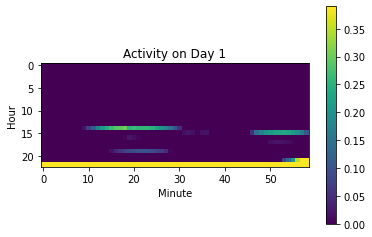

day: 2


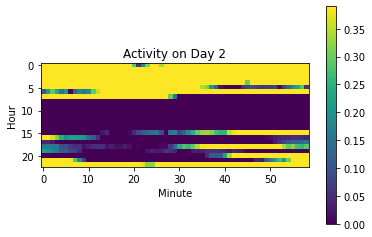

day: 3


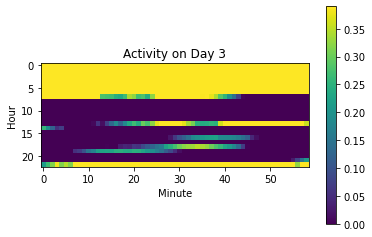

day: 4


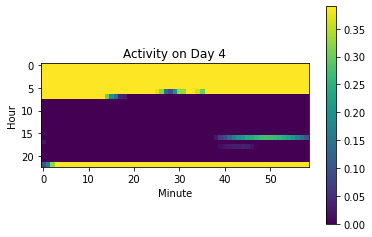

day: 5


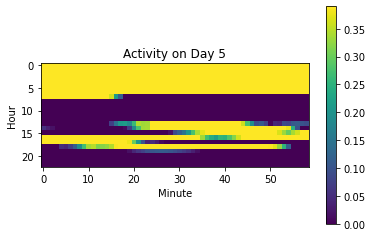

day: 6


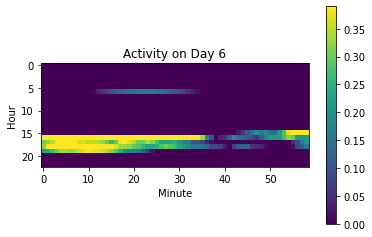

day: 7


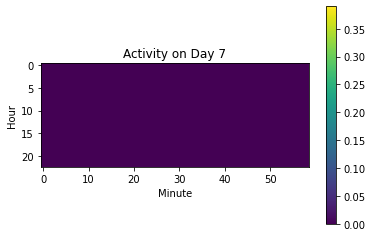

In [27]:
for day in range(0,7):
  sli = X_train[11, day, 0:23, 0:59, 0]
  print("day:", day + 1)
  plt.imshow(sli, interpolation='none', vmin=0, vmax=.39)
  plt.colorbar(orientation='vertical')
  plt.title("Activity on Day " + str(day+1))
  plt.xlabel("Minute")
  plt.ylabel("Hour")
  plt.show()

# Model Architecture 

Import certain files from Keras 

In [17]:
# Import Layers
from keras.layers import ConvLSTM2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling3D

In [18]:
# Model Structure
def create_model():
  model = Sequential()
  
  # Conv Layers 
  model.add(ConvLSTM2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(n_steps, n_length, n_width, n_features) ,return_sequences=True) )
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(ConvLSTM2D(filters=64, kernel_size=(2, 2), padding='valid', return_sequences= False))

  # Feed Forward Layers 
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return model

# Model Compilation & Fitting 

In [29]:
# Compile the model -----

with strategy.scope():
  # Create the model we defined above
  model = create_model()
  # Compile 
  model.compile(
    # Metrics 
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= tf.keras.metrics.AUC(),
    # Optimizer 
    optimizer= tf.keras.optimizers.Adam(
      learning_rate=0.00001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
    )
)

Fit the model

In [ ]:
%%time
# Balance Weights 
class_weights = {0: (266/7162),  # Custom Setting Class Weights 
                1: (6896/7162)}

# Fit the Model 
history = model.fit(
    X_train, y_train,
    epochs=90, 
    batch_size= 64,  
    validation_split=0.2,
    shuffle=False,
    class_weight=class_weights
)

#Note for future 
- Implement Early Stopping
- Save model h5 files into a folder (for george) 
- Save model output files (for michael to bootstrap)
- Create a CV loop